# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *H*

**Names:**

* *BAFFOU Jérémy*
* *BASSETO Antoine*
* *PINTO Andrea*

---

#### Instructions

*This is a template for part 1 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import networkx as nx
import pandas as pd
import os
import json

---

## 2.1 Exploration of real networks

### Exercise 2.1

Your first task is to explore network1 and analyze its properties.
1. Load the graph in your favorite data structure.
2. How many nodes and edges does the graph contain?

Load first the dataset into a pd dataframe :

In [2]:
network1 = pd.read_csv("../data/network1.csv", skiprows=1)
network1.head()

,# FromNodeId ToNodeId
0,11932
1,5128
2,7008
3,10476
4,9671


In [3]:
"""
create_edges_list(network):

Take as input a pandas DataFrame wich is the network.
It will iteratively go through each edges and add it to
the growing list of edges.
"""
def create_edges_list(network):
    indexes = network.index.drop_duplicates()
    neighbours = network["# FromNodeId ToNodeId"]
    edges_list = []
    for i in indexes:
        nodes = neighbours[i]
        if type(nodes) == pd.core.series.Series: # we have to be carefull as sometimes there is multiple neighbours 
            for j in nodes.values:               # represented in a pandas Series.
                edges_list.append((i,j))
        else:
            edges_list.append((i,nodes))
    return edges_list

In [4]:
edges = create_edges_list(network1)

In [5]:
G = nx.Graph()
G.add_edges_from(edges)

In [6]:
print(f'There are {len(list(G.nodes))} nodes in network1 !')
print(f'There are {len(list(G.edges))} edges in network1 !')

There are 13033 nodes in network1 !
There are 18584 edges in network1 !


### Exercise 2.2:  Node degree distribution
A convenient way to start exploring the structure of a graph is through its node degree distribution. <br>
Compute the node degree distribution of network1 and visualize it.

1. What kind of plot do you think is useful for this task?
2. Can you list some of the properties of the degree distribution?
3. Is it close to a well-known probability distribution? If so, provide an estimation of its
parameter(s)?
􏰀

**A1** An histogram is probably the best distribution representation

In [7]:
degrees = [degree for node, degree in G.degree]

  Node Degree
     9   1482
    23   1083
    20    691
     5    619
   126    467
   130    455
    31    379
    64    300
   102    292
   302    248


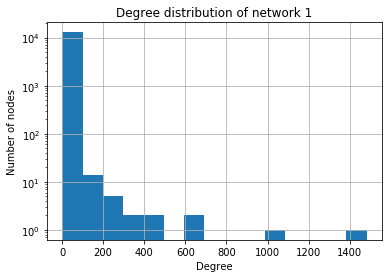

In [8]:
# Get the list of the degree per node
degrees = np.array(list(dict(G.degree()).values()))

# Get the indices of the nodes in decreasing order w.r.t their degree
ind = np.argsort(degrees)[::-1]

# Print the 10 first nodes and 
nodes_degree = ["%6d %6d" % (a, b) for a, b in zip(ind, degrees[ind])][:10]
print("%6s %6s" % ("Node", "Degree"))
print('\n'.join(nodes_degree))

# Plot the histogram of the PMF
plt.hist(degrees, bins=15)
plt.yscale('log')
plt.title("Degree distribution of network 1")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.grid()
plt.show()

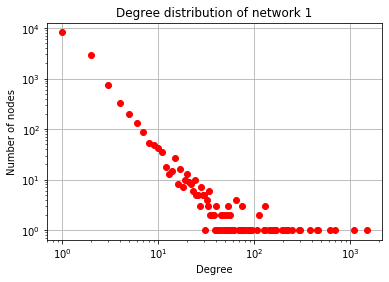

In [9]:
# Plot another view of the PMF
plt.plot(np.bincount(degrees), 'ro')
plt.xscale('log')
plt.yscale('log')
plt.title("Degree distribution of network 1")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.grid()
plt.show()

In [10]:
a = np.bincount(degrees)[1482]
print(np.max(degrees))
print(a)

1482
1


**A2** Some well known properties of the distribution are :

In [11]:
mean = np.mean(degrees)
std  = np.std(degrees)
var  = std * std

In [12]:
print(f'Degree distribution has \n \t mean : {mean} \n \t std  : {std} \n \t var  : {var}')

Degree distribution has 
 	 mean : 2.8518376429064682 
 	 std  : 20.859853773744813 
 	 var  : 435.1334994620157


**A3** Probability distribution is not a poisson man it is a zeta

In [13]:
# Compute the CCDF of the nodes' degree
ccdf = 1 - np.cumsum(np.bincount(degrees)) / len(list(G.nodes))
hihi = np.linspace(0, len(list(G.nodes)))

In [14]:
print(ccdf)

[1.00000000e+00 3.71441725e-01 1.49773652e-01 ... 7.67283051e-05
 7.67283051e-05 0.00000000e+00]


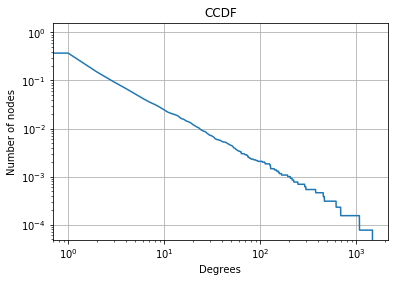

In [15]:
# Plot log-log plot of CCDF 
plt.plot(ccdf)
plt.xscale('log')
plt.yscale('log')
plt.title("CCDF")
plt.xlabel("Degrees")
plt.ylabel("Number of nodes")
plt.grid()
plt.show()

**TODO LIST**

- Say it's a ZETA distribution
- Compute it's gamme (slope)

### Exercise 2.3: Giant component
Real networks are generally not connected, but one connected component, i.e., the giant component, is usually much larger than the others.
1. Count the number of connected components in network1.
2. Is there a giant component ? If so, what is its size?

In [16]:
cc = list(nx.connected_components(G))

In [17]:
print(f'There are {len(cc)} components in network1')

There are 192 components in network1


In [18]:
print(nx.number_connected_components(G))

192


In [19]:
# Store cc in a deacreasing order list
sorted_cc = sorted(cc, key=len)[::-1]
sorted_asc_cc = sorted(cc, key=len)

In [20]:
dict_cc = ["%6d \t %6d" % (i + 1, len(sorted_cc[i])) for i in range(len(sorted_cc))][:5]
print("%6s \t %6s" % ("CC", "# Nodes"))
print('\n'.join(dict_cc))

    CC 	 # Nodes
     1 	  12576
     2 	     16
     3 	      7
     4 	      6
     5 	      5


In [21]:
print(f"Giant cc contains {len(sorted_cc[0]) / len(list(G.nodes))} of the network's nodes.")

Giant cc contains 0.9649351645822144 of the network's nodes.


### Exercise 2.4: Short paths & Small-worlds
In his book “Six Degrees” (2006), Duncan Watts explains the small-world effect by the now famous claim that every human on our planet is connected by an average of only “six degrees of separation”. Do you think that network1 is a small-world? Justify your answer.
Hint:
- What is the distribution of path lengths between any two nodes in the network?
- How fast is the network growing? I.e. what is the average number of nodes reachable
within a distance r (in number of hops) of any other node in the network?

In [22]:
dist = dict(nx.shortest_path_length(G))

In [27]:
df_dist = pd.DataFrame(dist)

In [28]:
df_dist.to_csv('hey.csv')

In [37]:
df_dist.head()

,0,11932,1,5128,2,7008,3,10476,4,9671,...,12452,12686,12693,12599,12971,12789,12974,12935,12850,13024
0,0.0,1.0,6.0,5.0,5.0,4.0,7.0,6.0,5.0,4.0,...,6.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,6.0,5.0
11932,1.0,0.0,5.0,4.0,4.0,3.0,6.0,5.0,4.0,3.0,...,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0
99,2.0,1.0,6.0,5.0,5.0,4.0,7.0,6.0,5.0,4.0,...,6.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,6.0,5.0
584,2.0,1.0,6.0,5.0,5.0,4.0,7.0,6.0,5.0,4.0,...,6.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,6.0,5.0
690,2.0,1.0,6.0,5.0,5.0,4.0,7.0,6.0,5.0,4.0,...,6.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,6.0,5.0


In [33]:
df_dist.tail()

,0,11932,1,5128,2,7008,3,10476,4,9671,...,12452,12686,12693,12599,12971,12789,12974,12935,12850,13024
11266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df = df_dist.replace(np.NaN, -1)

In [74]:
df[4].value_counts()

 3.0    6471
 4.0    3590
 2.0    1481
 5.0     883
-1.0     457
 6.0     121
 7.0      26
 8.0       2
 0.0       1
 1.0       1
Name: 4, dtype: int64

In [67]:
distribution = np.zeros(30) # index 0 : 0, 1 : 1, 28 : 28, 29 : -1

for i in range(df.shape[1]):
    serie = df[i].value_counts()
    for l in serie.index:
        distribution[int(l)] += serie[l]

In [68]:
print(df.shape)

(13033, 13033)


In [75]:
print(distribution[3])

34525164.0


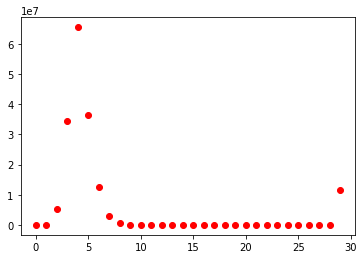

In [73]:
plt.plot(distribution, 'ro')

In [76]:
print(np.sum(distribution))
print(len(list(G.nodes))**2)

169859089.0
169859089


### Exercise 2.5: Network comparison
You will now focus on a second real network network2.csv located in the data/ folder.
1. Using the properties computed in Exercises 2.1, 2.2, 2.3 and 2.4 explore the structure of this network.
2. How does this network differ from the previous one?

In [77]:
network2 = pd.read_csv("../data/network2.csv", skiprows=1)
network2.head()

,# FromNodeId ToNodeId
135627,135630
135627,135623
135627,135625
135627,135626
137038,137040


In [80]:
edges2 = create_edges_list(network2)

In [81]:
G2 = nx.Graph()
G2.add_edges_from(edges2)

In [82]:
print(f'There are {len(list(G2.nodes))} nodes in network2 !')
print(f'There are {len(list(G2.edges))} edges in network2 !')

There are 26542 nodes in network2 !
There are 43516 edges in network2 !


In [84]:
degrees2 = [degree for node, degree in G2.degree]

  Node Degree
  1937      8
 18684      7
  9964      7
  2958      7
  5371      7
  4952      7
  4947      7
 10454      7
  9840      7
 13669      6


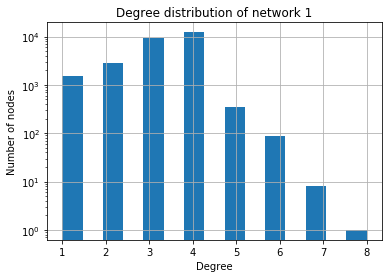

In [85]:
# Get the list of the degree per node
degrees2 = np.array(list(dict(G2.degree()).values()))

# Get the indices of the nodes in decreasing order w.r.t their degree
ind2 = np.argsort(degrees2)[::-1]

# Print the 10 first nodes and 
nodes_degree2 = ["%6d %6d" % (a, b) for a, b in zip(ind2, degrees2[ind2])][:10]
print("%6s %6s" % ("Node", "Degree"))
print('\n'.join(nodes_degree2))

# Plot the histogram of the PMF
plt.hist(degrees2, bins=15)
plt.yscale('log')
plt.title("Degree distribution of network 1")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.grid()
plt.show()

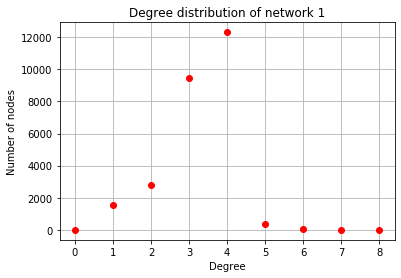

In [87]:
# Plot another view of the PMF
plt.plot(np.bincount(degrees2), 'ro')
plt.title("Degree distribution of network 1")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.grid()
plt.show()

In [90]:
mean2 = np.mean(degrees2)
std2  = np.std(degrees2)
var2  = std2 * std2

In [91]:
print(f'Degree distribution has \n \t mean : {mean2} \n \t std  : {std2} \n \t var  : {var2}')

Degree distribution has 
 	 mean : 3.2790294627383014 
 	 std  : 0.90164134609217 
 	 var  : 0.8129571169829002


In [93]:
# Compute the CCDF of the nodes' degree
ccdf2 = 1 - np.cumsum(np.bincount(degrees2)) / len(list(G2.nodes))
hihi = np.linspace(0, len(list(G2.nodes)))

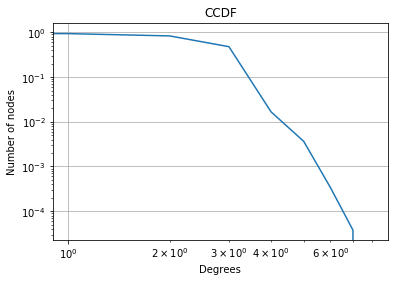

In [94]:
# Plot log-log plot of CCDF 
plt.plot(ccdf2)
plt.xscale('log')
plt.yscale('log')
plt.title("CCDF")
plt.xlabel("Degrees")
plt.ylabel("Number of nodes")
plt.grid()
plt.show()

In [95]:
cc2 = list(nx.connected_components(G2))

In [97]:
print(f'There are {len(cc2)} components in network2')

There are 5 components in network2


In [98]:
# Store cc in a deacreasing order list
sorted_cc2 = sorted(cc2, key=len)[::-1]
sorted_asc_cc2 = sorted(cc2, key=len)

In [100]:
dict_cc2 = ["%6d \t %6d" % (i + 1, len(sorted_cc2[i])) for i in range(len(sorted_cc2))][:5]
print("%6s \t %6s" % ("CC", "# Nodes"))
print('\n'.join(dict_cc2))

    CC 	 # Nodes
     1 	  26481
     2 	     30
     3 	     24
     4 	      5
     5 	      2


In [101]:
print(f"Giant cc contains {len(sorted_cc2[0]) / len(list(G2.nodes))} of the network's nodes.")

Giant cc contains 0.9977017557079346 of the network's nodes.


In [102]:
dist2 = dict(nx.shortest_path_length(G2))

KeyboardInterrupt: 

### Exercise 2.6: Network identification
Among the two networks you analyzed:
- One of them is the network of roads around the city of New-York, i.e., nodes are intersections and edges are roads between them.
- The other one corresponds to a subgraph of routers comprising the Internet, i.e., nodes are routers and edges are physical links between them.

Can you guess which one is which? Justify your answer.

- Network 1 is internet subgraph
- Network 2 is roads of NYC